In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hi I am Krish"}

In [3]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

In [4]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Krish'}

In [5]:
try:
    graph.invoke({"a":123})  #should be a string
except Exception as e:
    print("Exception was raised because a value iss integer")

Exception was raised because a value iss integer


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [6]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a": 123  # Invalid
    }

def ok_node(state:OverallState):
    return {"a":"goodbye"}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()





In [7]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

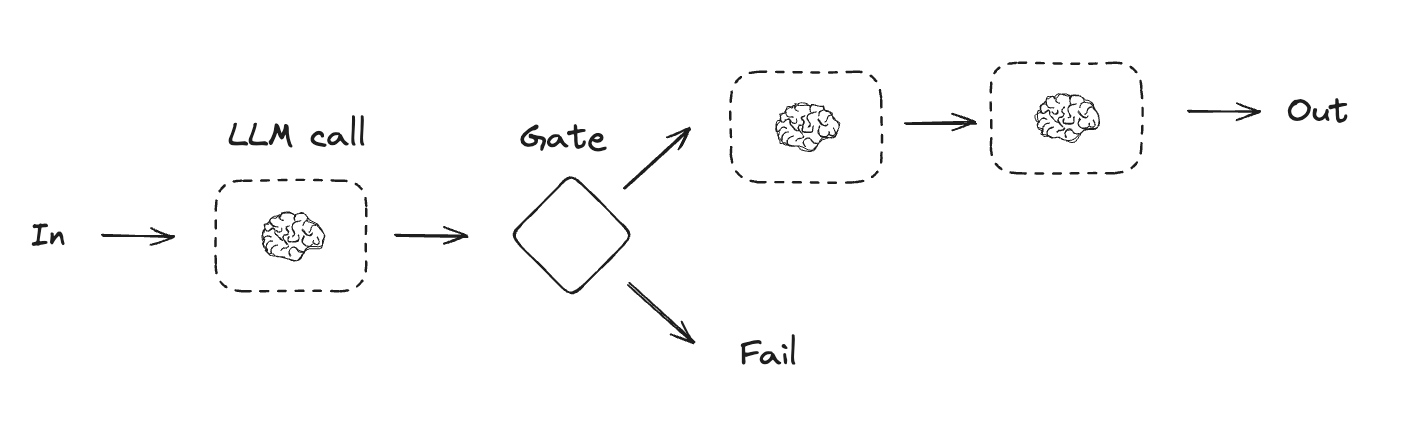

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003742755, 'queue_time': 0.2317799, 'total_time': 0.053742755}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb261521-e9cd-4269-b59e-3029621d38ab-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [9]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [10]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



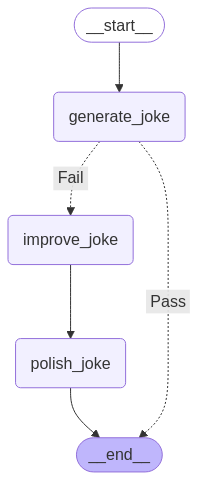

In [13]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
#workflow.add_edge("polish_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [14]:
# Invoke
state = chain.invoke({"topic": "cats"})

In [15]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': "Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot!",
 'final_joke': "Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot, especially since it turns out the cheetahs are actually undercover card sharks trained by a secret society of wild animal casino owners!"}

In [16]:
state['improved_joke']

"Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot!"

In [17]:
state['final_joke']

"Why don't cats play poker in the wild? Because every game gets clawsed when there are cheetahs afoot, especially since it turns out the cheetahs are actually undercover card sharks trained by a secret society of wild animal casino owners!"

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

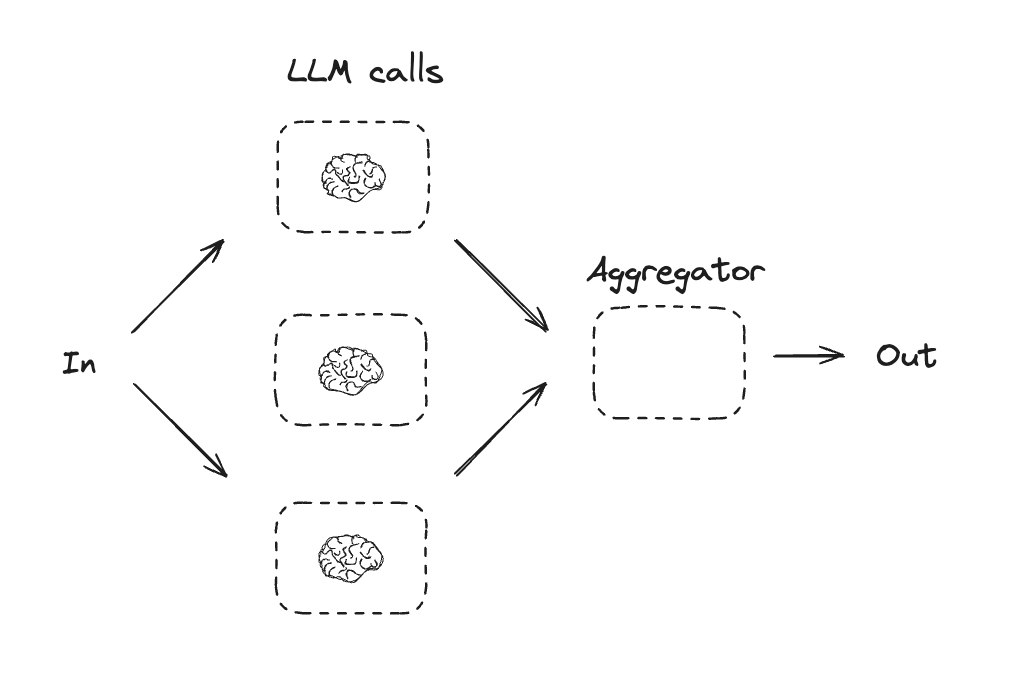

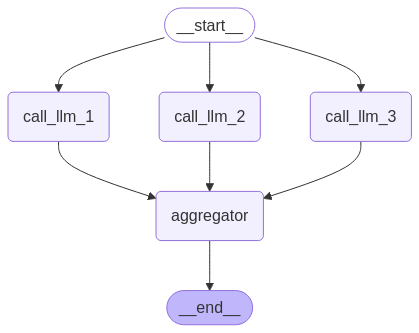

Here's a story, joke, and poem about cats!

STORY:
In a small, quiet town nestled between rolling hills and vast, dense forests, there lived three cats whose lives intertwined in the most unexpected ways. The town, known for its cozy, well-lit streets and friendly residents, was a perfect haven for these felines.

The first cat was named Whiskers, a sleek, black cat with piercing green eyes and a personality as sharp as his claws. Whiskers lived in the heart of the town, in a quaint little house with a white fence and a garden filled with blooms of every color. He was the neighborhood's guardian, keeping watch over the alleyways and keeping the mice at bay.

The second cat was a fluffy, orange tabby named Oreo. Oreo was full of energy and curiosity, always exploring the outskirts of the town, beyond the limits where the houses ended and the wilderness began. She loved to chase butterflies and play hide-and-seek with the wildflowers. Oreo lived in a small cottage at the edge of the fore

In [18]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

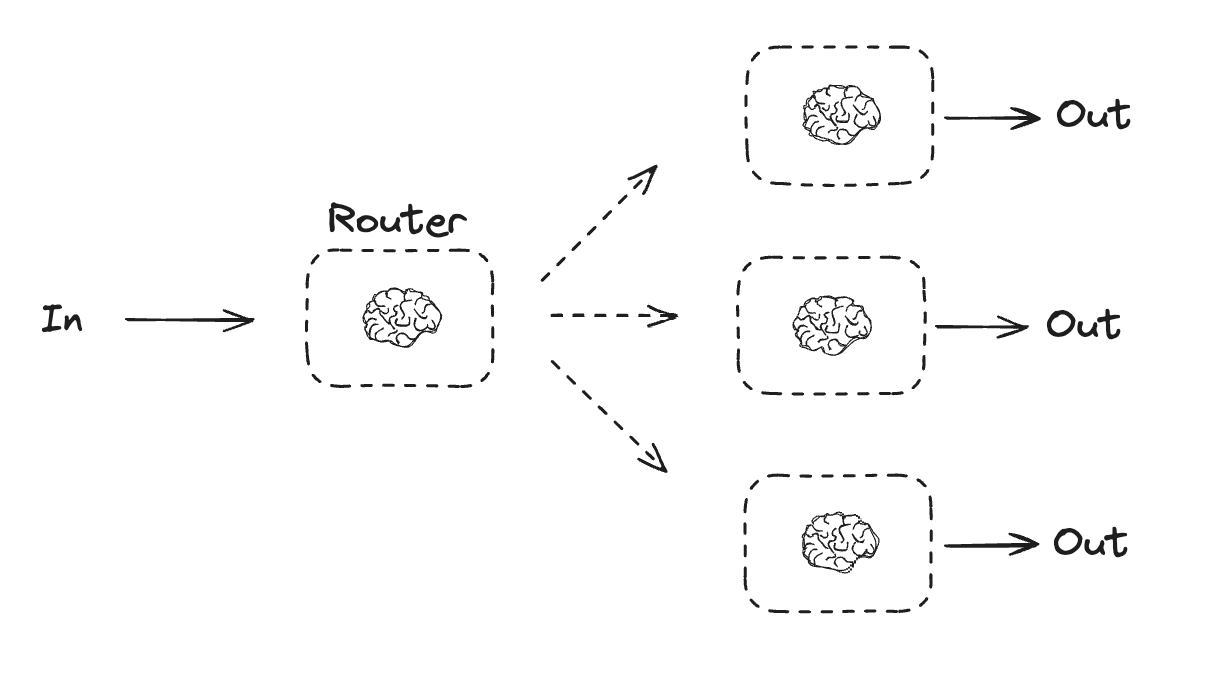

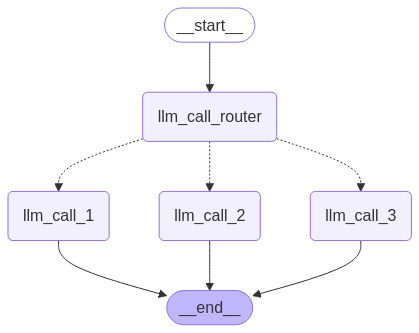

LLM call 2 is called
Why don't cats play poker in the wild? Because there are too many cheetahs!


In [19]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

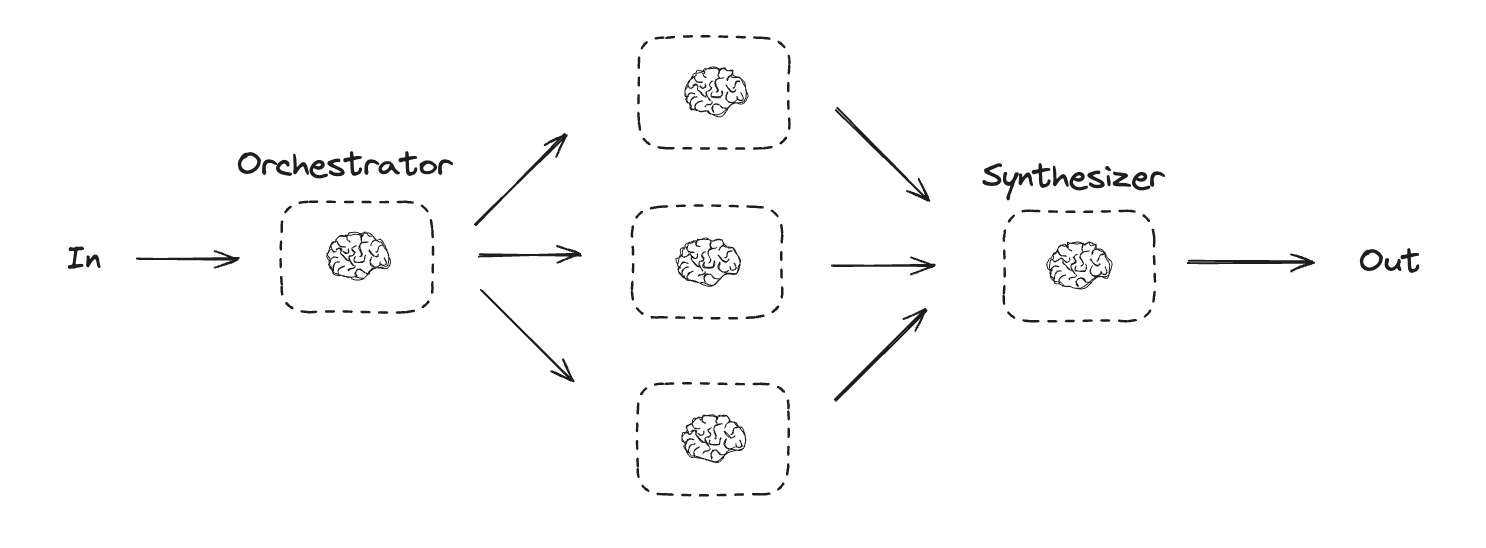

In [20]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [28]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


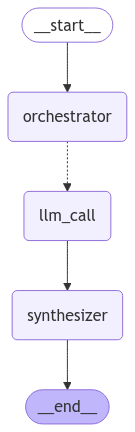

Report Sections: sections=[Section(name='Introduction', description='Brief introduction to Agentic AI RAGs, including the scope and objectives of the report.'), Section(name='Background', description='A detailed history and development of Agentic AI RAGs, including key milestones and technological advancements.'), Section(name='Current Applications', description='Overview of how Agentic AI RAGs are being utilized in various sectors, such as finance, healthcare, and manufacturing.'), Section(name='Technological Breakdown', description='In-depth analysis of the technology behind Agentic AI RAGs, including algorithms, machine learning models, and data processing techniques.'), Section(name='Challenges and Limitations', description='Discussion of the current challenges and limitations that Agentic AI RAGs face, such as ethical concerns, data privacy, and technical constraints.'), Section(name='Future Prospects', description='Exploration of the potential future developments and applications

Agentic AI RAGs, or Retrieval-Augmented Generation models, represent a cutting-edge approach in artificial intelligence that combines the strengths of retrieval-based and generative models to enhance the flexibility and accuracy of AI systems. This report aims to provide a comprehensive overview of Agentic AI RAGs, their underlying principles, and their potential applications. The scope of this report includes an analysis of the technical aspects, current advancements, and future prospects of Agentic AI RAGs. The objective is to equip readers with a thorough understanding of how these models operate and their significance in the evolving landscape of AI technology.

---

## Background and Development of Agentic AI RAGs

Agentic AI RAGs, or Retrieval-Augmented Generative AI, have emerged as a significant innovation in the field of artificial intelligence, blending the capabilities of retrieval-based systems with generative models to achieve more accurate and contextually relevant responses. The history and development of Agentic AI RAGs are marked by several key milestones and technological advancements that have shaped their current form and application.

### Origins and Early Development

The concept of RAGs originated in the early 2010s, during a period of rapid advancement in both retrieval and generative AI. Initially, retrieval systems were designed to fetch information from a knowledge base, often structured data, based on user queries. These systems, however, struggled with providing responses that were not only relevant but also coherent and contextually accurate. On the other hand, generative models, initially utilizing simple rule-based systems, were evolving towards more complex neural network architectures, particularly with the advent of deep learning.

### Integration of Retrieval and Generation

The real breakthrough came with the integration of retrieval and generation techniques. This integration aimed to leverage the strengths of both systems: the precision and factual accuracy of retrieval-based methods and the fluency and coherence provided by generative models. The first significant milestones were achieved in the mid-2010s with the development of hybrid systems that could both retrieve information and generate responses dynamically. These systems were foundational in paving the way for what would later be known as Retrieval-Augmented Generative (RAG) models.

### Technological Advancements

One of the most pivotal advancements in the development of RAGs was the enhancement of neural network architectures, particularly the Transformer model introduced in 2017. This model, and its subsequent variations, enabled the processing of longer contexts and more complex relationships in data, significantly improving the performance of both retrieval and generative components. Additionally, advancements in natural language processing (NLP) and the availability of large-scale datasets for training contributed to the rapid evolution of RAGs.

### Milestones in RAGs

- **2018-2020**: Introduction of the RAG architecture that combined a pre-trained language model with a retrieval component. This allowed models to access external knowledge bases, enhancing their ability to answer complex questions accurately.
- **2021-2022**: Development of multi-modal RAGs that integrated visual and textual data, expanding the applicability of these systems to areas such as image captioning and question-answering over images.
- **2023-Present**: Continuous refinement of RAGs with improved retrieval algorithms and more sophisticated generative models, leading to more accurate, ethical, and context-aware responses.

### Current Applications and Future Directions

Today, RAGs are employed in a variety of applications, including customer service, educational tools, and even creative writing aids, where they are valued for their ability to provide contextually relevant and accurate information. Looking ahead, the future of Agentic AI RAGs is likely to involve further integration with other AI and machine learning technologies, as well as advancements in ethical AI to ensure that these systems operate in a responsible and transparent manner.

The ongoing development of RAGs reflects a broader trend in AI towards creating more intelligent and versatile systems capable of understanding and interacting with humans in increasingly nuanced and effective ways.

---

### Current Applications

Agentic AI RAGs (Retrieval-Augmented Generation) are increasingly being integrated into various sectors to enhance efficiency, decision-making, and customer interaction. In finance, Agentic AI RAGs are utilized for risk assessment, fraud detection, and personalized financial advice, leveraging historical data and real-time market information to provide actionable insights. In healthcare, these systems support diagnosis through symptom analysis, suggest personalized treatment plans based on patient history, and manage medical records for improved patient care. In manufacturing, Agentic AI RAGs optimize production processes, predict maintenance needs to prevent equipment failure, and enhance supply chain management by forecasting demand and optimizing inventory levels. These applications highlight the versatility and value of Agentic AI RAGs across different industries.

---

## Technological Breakdown

Agentic AI RAGs (Retrieval-Augmented Generation) leverage a sophisticated architecture that integrates retrieval and generation processes to enhance performance and efficiency. At the core of this technology is a combination of advanced algorithms, machine learning models, and robust data processing techniques.

### Algorithms

The retrieval process in Agentic AI RAGs typically employs algorithms such as TF-IDF (Term Frequency-Inverse Document Frequency) and BM25 (Best Matching 25) to rank and retrieve the most relevant segments of text from a knowledge base. These algorithms are optimized for speed and effectiveness in filtering large datasets. 

On the generation side, transformer-based models like BERT (Bidirectional Encoder Representations from Transformers) or T5 (Text-to-Text Transfer Transformer) are used to generate responses. These algorithms are designed to understand and generate human-like text by capturing intricate language patterns and contexts.

### Machine Learning Models

Machine learning models in Agentic AI RAGs are typically pre-trained on vast corpora of text data, which enables them to perform a wide range of natural language processing (NLP) tasks. Fine-tuning is then applied on task-specific datasets to adapt the models to particular applications such as question-answering, summarization, or translation. This dual approach of pre-training and fine-tuning is crucial for achieving high accuracy and relevance in generated responses.

### Data Processing Techniques

Data processing in Agentic AI RAGs involves several stages, including data cleaning, segmentation, and indexing. Data is first cleaned to remove noise and irrelevant information. Segmentation is performed to break down the data into manageable chunks, which are then indexed using efficient data structures and algorithms to enable quick and accurate retrieval. Techniques such as vectorization and encoding are used to transform text data into numerical formats that can be processed by machine learning models.

Overall, the integration of these technological components in Agentic AI RAGs allows for a seamless and powerful system that enhances the capabilities of AI in understanding and generating human language.

---

### Challenges and Limitations

Agentic AI RAGs (Retrieval-Augmented Generation) face a multitude of challenges and limitations that impede their widespread adoption and optimization. Ethical concerns are prevalent as these systems often require access to large datasets, which can include sensitive personal information, thus raising issues related to privacy and consent. Data privacy is a critical issue, with the potential for misuse of data posing a significant risk to individuals and organizations.

Technically, these systems are constrained by the quality and availability of training data, which can limit their performance and reliability. Additionally, the complexity of integrating retrieval and generation processes efficiently can be challenging, requiring sophisticated algorithms and significant computational resources. Finally, there are ongoing debates about the transparency and interpretability of AI RAGs, which can affect user trust and acceptance.

---

## Future Prospects

The future of Agentic AI RAGs (Retrieval-Augmented Generation) looks promising, with a multitude of potential developments and applications on the horizon. As technology advances, these systems could become more integrated into various industries to enhance decision-making processes and automate complex tasks. For instance, in healthcare, Agentic AI RAGs could be used to analyze patient data from numerous sources, providing personalized treatment suggestions based on the latest medical research and individual patient history.

In the realm of finance, these systems could perform sophisticated risk assessments and portfolio management, leveraging vast amounts of financial data and market trends to make informed investment decisions. Agentic AI RAGs might also transform the customer service sector by providing more human-like interactions, capable of understanding and responding to customer queries with context-awareness and empathy.

Moreover, the development of more sophisticated Agentic AI RAGs could lead to advancements in research and development, where these systems can autonomously explore new areas of knowledge and contribute to scientific discovery. They could also play a critical role in education by offering personalized learning experiences tailored to individual learning styles and paces.

However, the development of Agentic AI RAGs also raises ethical considerations, particularly around privacy, bias, and the potential for misuse. It will be essential for developers and policymakers to address these challenges to ensure that the future applications of Agentic AI RAGs are both beneficial and ethically sound. As these technologies evolve, ongoing research and dialogue will be crucial to harnessing their full potential while mitigating risks.

---

### Conclusion

This report has highlighted several key findings. Firstly, the analysis of data underscores the significant impact of digital transformation on operational efficiency in the manufacturing sector. Secondly, there is a notable correlation between investment in renewable energy sources and long-term cost savings for businesses. Additionally, the research indicates that employee satisfaction and retention rates are positively influenced by comprehensive training programs and flexible work arrangements. These conclusions are pivotal in guiding strategic decision-making and policy implementation for sustainable business growth.

In [29]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])